内容来自 [七年实现财富自由|雪球](https://xueqiu.com/u/1164950442)

In [8]:
import pandas as pd

import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei'] # 设置支持中文的字体
plt.rcParams['axes.unicode_minus'] = False # 正确显示负号

import bt
print(bt.__version__)

1.1.2


如果有报错
```bash
ModuleNotFoundError: No module named 'bt'
```

> 需要安装 bt 包

```bash
! pip install bt --upgrade --user -i https://pypi.tuna.tsinghua.edu.cn/simple
```

# 数据准备

In [19]:
symbols = ['513100','513500']#,'510500','159915','510880'
symbols = {#'513100':'纳指100',
           #'513500':'标普500',
           '510300':'沪深300',
           #'159915':'创业板',
           '518880':'黄金',
           #'512890':'红利低波',
           #'159985':'豆粕',
           '511880':'银华日利-货币ETF'
          }

dfs = []
for s in symbols.keys():
    df = pd.read_csv(f'data/{s}.csv')
    df['symbol'] = s
    dfs.append(df)
    df_all = pd.concat(dfs,axis=0)
    
df_all

,high,low,close,open,volume,date,symbol
0,2.607,2.544,2.604,2.551,12775188,2012-05-28,510300
1,2.661,2.602,2.644,2.602,7149490,2012-05-29,510300
2,2.647,2.633,2.636,2.642,2658872,2012-05-30,510300
3,2.645,2.613,2.630,2.621,1781560,2012-05-31,510300
4,2.660,2.620,2.630,2.629,1793500,2012-06-01,510300
...,...,...,...,...,...,...,...
2974,132.821,132.812,132.821,132.813,1071268,2025-07-15,511880
2975,132.827,132.821,132.827,132.823,1234589,2025-07-16,511880
2976,132.832,132.827,132.830,132.829,1004811,2025-07-17,511880
2977,132.838,132.830,132.833,132.838,1605493,2025-07-18,511880


In [20]:
df_close = pd.pivot(df_all,columns='symbol',index='date',values='close')
new_cols = {}
for c in df_close.columns:
    new_cols[c] = symbols[c]
print(new_cols)
df_close.rename(columns = new_cols,inplace=True)
df_close.index  = pd.to_datetime(df_close.index)
df_close = df_close.dropna() #对齐数据
df_close = df_close.ffill()  # 前向填充
df_close

{'510300': '沪深300', '511880': '银华日利-货币ETF', '518880': '黄金'}


symbol,沪深300,银华日利-货币ETF,黄金
date,,,
2013-07-29,2.254,101.190,2.626
2013-07-30,2.267,101.199,2.646
2013-07-31,2.272,101.226,2.657
2013-08-01,2.331,101.240,2.643
2013-08-02,2.327,101.291,2.578
...,...,...,...
2025-07-15,4.835,132.821,7.436
2025-07-16,4.826,132.827,7.402
2025-07-17,4.859,132.830,7.397


# nb框架的策略

In [21]:
# 定义两个策略
# 每个月更新一次权重
s_buy_rebalance = bt.Strategy('买入并持有-等权-月度再平衡', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

# 只买入一次，就是买入并持有
s_buy_and_hold = bt.Strategy('买入并持有-等权-不平衡', [bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

s_risk_parity = bt.Strategy('买入并持有-风阶平价-不平衡', [
                        bt.algos.RunAfterDays(days=100),
                        bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighERC(),
                       bt.algos.Rebalance()])

s_risk_parity_rebalance = bt.Strategy('买入并持有-风阶平价-月度再平衡', [
                        bt.algos.RunAfterDays(days=100),
                        bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighERC(),
                       bt.algos.Rebalance()])

strategies = [s_buy_rebalance,s_buy_and_hold, s_risk_parity, s_risk_parity_rebalance]

100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


<Axes: title={'center': 'Equity Progression'}>

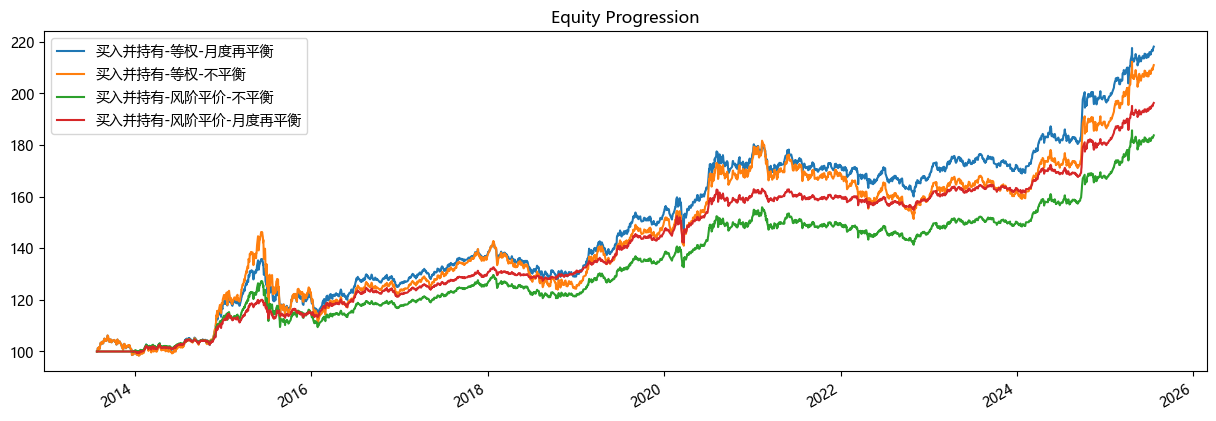

In [22]:
# 运行回测
test1 = bt.Backtest(s_buy_rebalance, df_close)
test2 = bt.Backtest(s_buy_and_hold, df_close)
test3 = bt.Backtest(s_risk_parity, df_close)
test4 = bt.Backtest(s_risk_parity_rebalance, df_close)
res = bt.run(test1, test2, test3, test4)

# 输出结果
res.plot()

In [23]:
res.display()

Stat                 买入并持有-等权-月度再平衡    买入并持有-等权-不平衡    买入并持有-风阶平价-不平衡    买入并持有-风阶平价-月度再平衡
-------------------  ----------------------------  ------------------------  ----------------------------  --------------------------------
Start                2013-07-28                    2013-07-28                2013-07-28                    2013-07-28
End                  2025-07-21                    2025-07-21                2025-07-21                    2025-07-21
Risk-free rate       0.00%                         0.00%                     0.00%                         0.00%

Total Return         118.11%                       110.94%                   83.74%                        96.28%
Daily Sharpe         0.85                          0.68                      0.87                          1.24
Daily Sortino        1.37                          1.06                      1.36                          2.04
CAGR                 6.73%                         6.43%                     5.21%

# 加载数据的类

In [41]:
class DataLoader:
    def load_df_from_csvs(self, symbols: list[str]):
        dfs = []
        for s in symbols:
            df = pd.read_csv(f'data/{s}.csv')
            df['symbol'] = s
            dfs.append(df)
            df_all = pd.concat(dfs,axis=0)
            
        return df_all

    def get_col_df_by_symbols(self, symbols: list[str], col="close"):
        df_all = self.load_df_from_csvs(symbols=symbols)
        if col not in df_all.columns:
            print("列不存在")
            return None
        df_close = pd.pivot(df_all,columns='symbol',index='date',values='close')
        df_close.index  = pd.to_datetime(df_close.index)
        # df_close = df_close.dropna() #对齐数据
        # df_close = df_close.ffill()  # 前向填充
        return df_close

In [42]:
loader = DataLoader()
df_col = loader.get_col_df_by_symbols(symbols = ["510300", "159915"])
df_col

symbol,159915,510300
date,,
2011-12-09,0.797,NaN
2011-12-12,0.790,NaN
2011-12-13,0.768,NaN
2011-12-14,0.760,NaN
2011-12-15,0.752,NaN
...,...,...
2025-07-18,2.252,4.889
2025-07-21,2.275,4.914
2025-07-22,2.289,4.958


# 绝对收益型策略组合

In [43]:
loader = DataLoader()
df_ana = loader.get_col_df_by_symbols(symbols = ["510300", "511260", "518880", "511880"])
symbols = {#'513100':'纳指100',
           #'513500':'标普500',
           '510300':'沪深300',
           '518880':'黄金ETF',
           '511260':'十年国债ETF',
           '511880':'货币ETF'
          }
df_ana.rename(columns = symbols,inplace=True)
df_ana = df_ana.dropna() #对齐数据
df_ana = df_ana.ffill()  # 前向填充

df_ana

symbol,沪深300,十年国债ETF,货币ETF,黄金ETF
date,,,,
2017-08-24,4.015,99.487,115.631,2.751
2017-08-25,4.081,99.809,115.647,2.749
2017-08-28,4.125,99.979,115.647,2.762
2017-08-29,4.117,99.773,115.658,2.792
2017-08-30,4.113,99.877,115.664,2.760
...,...,...,...,...
2025-07-18,4.889,136.666,132.833,7.403
2025-07-21,4.914,136.540,132.833,7.446
2025-07-22,4.958,136.409,132.832,7.474


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


<Axes: title={'center': 'Equity Progression'}>

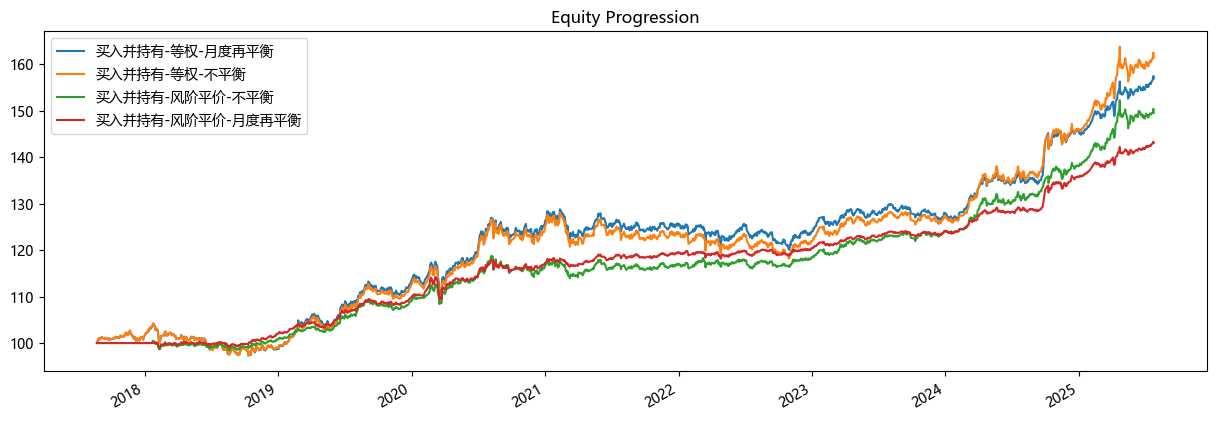

In [44]:
# 运行回测
test1 = bt.Backtest(s_buy_rebalance, df_ana)
test2 = bt.Backtest(s_buy_and_hold, df_ana)
test3 = bt.Backtest(s_risk_parity, df_ana)
test4 = bt.Backtest(s_risk_parity_rebalance, df_ana)
res = bt.run(test1, test2, test3, test4)

# 输出结果
res.plot()

In [45]:
res.display()

Stat                 买入并持有-等权-月度再平衡    买入并持有-等权-不平衡    买入并持有-风阶平价-不平衡    买入并持有-风阶平价-月度再平衡
-------------------  ----------------------------  ------------------------  ----------------------------  --------------------------------
Start                2017-08-23                    2017-08-23                2017-08-23                    2017-08-23
End                  2025-07-24                    2025-07-24                2025-07-24                    2025-07-24
Risk-free rate       0.00%                         0.00%                     0.00%                         0.00%

Total Return         56.89%                        61.38%                    49.49%                        43.04%
Daily Sharpe         1.11                          1.09                      1.41                          1.70
Daily Sortino        1.82                          1.75                      2.23                          2.76
CAGR                 5.85%                         6.23%                     5.21%